In [13]:
import autograd

import autograd.numpy as np
import autograd.scipy as sp
from numpy.polynomial.hermite import hermgauss

from vb_lib import structure_model_lib, data_utils, cavi_lib
import vb_lib.structure_optimization_lib as str_opt_lib

import paragami
import vittles

from copy import deepcopy

import argparse
import distutils.util

import os

import time

import matplotlib.pyplot as plt
%matplotlib inline  

from bnpmodeling_runjingdev import cluster_quantities_lib, modeling_lib


In [14]:
np.random.seed(53453)

# Draw data

In [15]:
n_obs = 200
n_loci = 4000
n_pop = 4

In [16]:
g_obs, true_pop_allele_freq, true_ind_admix_propn = \
    data_utils.draw_data(n_obs, n_loci, n_pop)

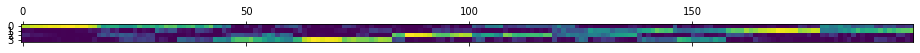

In [17]:
plt.matshow(true_ind_admix_propn.T)

In [18]:
g_obs.shape

(200, 4000, 3)

# Get prior

In [19]:
prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

print(prior_params_paragami)

prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)

OrderedDict:
	[dp_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_alpha] = NumericArrayPattern (1,) (lb=0.0, ub=inf)
	[allele_prior_beta] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


# Get VB params 

In [20]:
k_approx = 12

In [21]:
gh_deg = 8
gh_loc, gh_weights = hermgauss(8)

In [22]:
use_logitnormal_sticks = False

vb_params_dict, vb_params_paragami = \
    structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                    use_logitnormal_sticks = use_logitnormal_sticks)
    
print(vb_params_paragami)

OrderedDict:
	[pop_freq_beta_params] = NumericArrayPattern (4000, 12, 2) (lb=0.0, ub=inf)
	[ind_mix_stick_beta_params] = NumericArrayPattern (200, 11, 2) (lb=0.0, ub=inf)


## Initialize 

In [23]:
t0 = time.time()
vb_params_dict = \
        structure_model_lib.set_init_vb_params(g_obs, k_approx, vb_params_dict,
                                                use_logitnormal_sticks)

print('init time: {:.03f}sec'.format(time.time() - t0))

vb_params_init_dict = deepcopy(vb_params_dict)

init time: 0.802sec


# Run CAVI

In [24]:
vb_cavi_dict, vb_opt, ez_opt_cavi, kl_vec_cavi, time_vec_cavi = \
    cavi_lib.run_cavi(g_obs, deepcopy(vb_params_init_dict), 
                        vb_params_paragami,
                        prior_params_dict,
                        use_logitnormal_sticks, 
                        max_iter = 10,
                        x_tol = 1e-2)


iteration [1]; kl:1215530.458622; elapsed: 6.8953secs
iteration [2]; kl:1060790.372551; elapsed: 6.6702secs
iteration [3]; kl:1038274.725498; elapsed: 7.0082secs
iteration [4]; kl:1030953.549529; elapsed: 6.5023secs
iteration [5]; kl:1026950.476618; elapsed: 6.3805secs
iteration [6]; kl:1024088.37716; elapsed: 6.287secs
iteration [7]; kl:1021832.934845; elapsed: 6.1797secs
iteration [8]; kl:1019985.22594; elapsed: 6.1911secs
iteration [9]; kl:1018435.986399; elapsed: 6.265secs
Done. Warning, max iterations reached. 


# Run stochastic CAVI

In [26]:
e_z_init = cavi_lib.get_ez_from_vb_params_dict(g_obs, vb_params_dict, use_logitnormal_sticks, 
                                              gh_loc = 0, gh_weights = 0)

In [27]:
vb_svi_dict, ez_opt_svi, kl_vec_svi, time_vec_svi = \
    cavi_lib.run_svi(g_obs, deepcopy(vb_params_init_dict),
                prior_params_dict,
                e_z_init,
                use_logitnormal_sticks,
                batchsize = round(n_obs / 10),
                x_tol = 1e-2,
                max_iter = 100,
                print_every = 10, 
                local_x_tol = 1e16)

iteration [10]; kl:1475064.673679; elapsed: 6.2868secs
iteration [20]; kl:1224113.510729; elapsed: 6.6421secs
iteration [30]; kl:1096259.67528; elapsed: 6.1666secs
iteration [40]; kl:1058141.458317; elapsed: 6.173secs
iteration [50]; kl:1031919.081316; elapsed: 6.8276secs
iteration [60]; kl:1028663.895078; elapsed: 6.5397secs
iteration [70]; kl:1027057.323809; elapsed: 6.4304secs
iteration [80]; kl:1025851.674978; elapsed: 6.465secs
iteration [90]; kl:1024798.427538; elapsed: 6.3777secs
iteration [100]; kl:1023896.516476; elapsed: 6.8655secs
iteration [110]; kl:1023042.549038; elapsed: 6.3319secs
iteration [120]; kl:1022267.671191; elapsed: 6.3524secs
iteration [130]; kl:1021588.517807; elapsed: 6.3798secs
iteration [140]; kl:1020987.635822; elapsed: 6.6435secs
iteration [150]; kl:1020491.877054; elapsed: 6.5729secs
iteration [160]; kl:1020019.34365; elapsed: 6.4883secs
iteration [170]; kl:1019562.214187; elapsed: 6.4369secs
iteration [180]; kl:1019105.537672; elapsed: 6.3504secs
itera

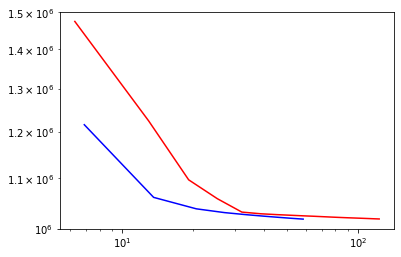

In [28]:
plt.loglog(time_vec_cavi[1:], kl_vec_cavi, 'b')
plt.loglog(time_vec_svi[1:], kl_vec_svi, 'r')

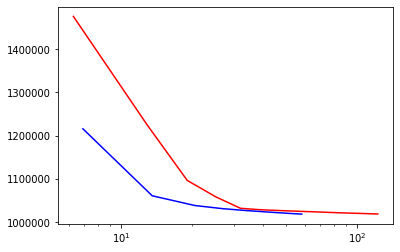

In [30]:
plt.semilogx(time_vec_svi[1:], kl_vec_svi, 'r')
plt.semilogx(time_vec_cavi[1:], kl_vec_cavi, 'b')

In [ ]:
def benchmark_one_cavi_cycle(n_obs, n_loci, n_pop, k_approx, run_cavi,  
                                vb_params_dict = None): 
    # draw data 
    g_obs, _, _ = \
        data_utils.draw_data(n_obs, n_loci, n_pop)
    
    # get prior 
    prior_params_dict, prior_params_paragami = \
    structure_model_lib.get_default_prior_params()

    prior_params_free = prior_params_paragami.flatten(prior_params_dict, free = True)
    
    # set vb_params
    use_logitnormal_sticks = False
    _, vb_params_paragami = \
        structure_model_lib.get_vb_params_paragami_object(n_obs, n_loci, k_approx,
                                        use_logitnormal_sticks = use_logitnormal_sticks)
    
    if vb_params_dict is None: 
        vb_params_dict = vb_params_paragami.random()
    
    
    if run_cavi: 
        _, _, _, time_vec = \
            cavi_lib.run_cavi(g_obs, deepcopy(vb_params_dict), 
                                prior_params_dict,
                                use_logitnormal_sticks, 
                                max_iter = 2,
                                f_tol = -1, 
                                x_tol = 1e-2)
    else: 
        # run svi 
        _ = cavi_lib.run_svi(g_obs, deepcopy(vb_params_dict),
                prior_params_dict,
                e_z_init = np.random.rand((n_obs, n_loci, k_approx + 1, 2)),
                use_logitnormal_sticks = use_logitnormal_sticks,
                batchsize = 1,
                x_tol = 1e-2,
                max_iter = 2,
                print_every = 1)
        
    return time_vec[1], vb_params_dict